In [6]:
import CONSTANTS
from functions import *
import warnings
import torch
import torch.nn as nn
import math
import numpy as np
import pandas as pd
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
from transformer_classes import *
from tqdm import tqdm
from sklearn.metrics import *

warnings.filterwarnings('ignore')

# Transformer

Objective: predict change in BTC price given features

## Prepare data
Create tupled dataset


In [7]:
data = pd.read_csv(f'../{fullDataPath('BTC')}')
data['gradient'] = data['close'].diff().fillna(0.0)
data

,time,low,high,open,close,volume,change,pct_change,timestamp,value,...,Unnamed: 0.2,Unnamed: 0.1,Unnamed: 0,title,date,link,text,sentiment,score,gradient
0,2025-06-17,104783.25,107792.90,106853.38,104878.18,2941.059097,-1975.20,-1.848514,1970-01-01,51.0,...,0.0,0.0,0.0,-,NaN,-,-,-,0.0,0.00
1,2025-06-16,104982.26,109000.00,105600.21,106853.38,5952.783796,1253.17,1.186712,2025-06-16,51.0,...,0.0,0.0,0.0,-,NaN,-,-,-,0.0,1975.20
2,2025-06-15,104505.05,106184.13,105465.42,105599.25,1722.809452,133.83,0.126895,2025-06-15,50.0,...,0.0,0.0,0.0,-,NaN,-,-,-,0.0,-1254.13
3,2025-06-14,104351.72,106264.36,106114.53,105465.42,2256.484581,-649.11,-0.611707,2025-06-14,52.0,...,0.0,0.0,0.0,-,NaN,-,-,-,0.0,-133.83
4,2025-06-13,102746.01,106233.00,105716.45,106118.70,7440.850143,402.25,0.380499,2025-06-13,54.0,...,0.0,0.0,0.0,-,NaN,-,-,-,0.0,653.28
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3706,2015-07-24,276.43,291.52,277.23,289.12,7362.469083,11.89,4.288858,1970-01-01,51.0,...,0.0,0.0,0.0,-,NaN,-,-,-,0.0,-0.58
3707,2015-07-23,276.28,279.75,277.96,277.39,5306.919575,-0.57,-0.205065,1970-01-01,51.0,...,0.0,0.0,0.0,-,NaN,-,-,-,0.0,-11.73
3708,2015-07-22,275.01,278.54,277.33,277.89,4687.909383,0.56,0.201926,1970-01-01,51.0,...,0.0,0.0,0.0,-,NaN,-,-,-,0.0,0.50
3709,2015-07-21,276.85,281.27,279.96,277.32,4943.559434,-2.64,-0.942992,1970-01-01,51.0,...,0.0,0.0,0.0,-,NaN,-,-,-,0.0,-0.57


In [8]:
# Convert time to datetime if it's not already
data['time'] = pd.to_datetime(data['time'], errors='coerce')
data = data.dropna(subset=['time'])

# Extract date component
data['date'] = data['time'].dt.date

# Group by date and aggregate values (one row per day)
# Hard coded change later
daily_data = (
    data
    .groupby('date')
    .agg(
        close=('close', 'last'),  # Take the last close price of the day
        avg_sentiment=('score', 'mean'),  # Average sentiment for the day
        tweet_count=('score', 'count'),   # Number of observations per day
        gradient=('gradient', 'last'),     # Take the last gradient of the day
        volume=('volume', 'last'),          # Total volume for the day
        BB_Lower=('BB_Lower', 'last'),  # Last value of BB lower band
        BB_Middle=('BB_Middle', 'last'),  # Last value of BB middle band
        BB_Upper=('BB_Upper', 'last'),  # Last value of BB upper band
        SMA_50=('SMA_50', 'last'),  # Last value of SMA 50
        Volume_MA_20=('Volume_MA_20', 'last')  # Last value of Volume MA 20
    )
    .reset_index()
)

# Convert date back to datetime format if needed
daily_data['time'] = pd.to_datetime(daily_data['date'])
daily_data = daily_data.drop('date', axis=1)

# Sort by time
daily_data = daily_data.sort_values('time')
daily_data.set_index('time', inplace=True)
daily_data

,close,avg_sentiment,tweet_count,gradient,volume,BB_Lower,BB_Middle,BB_Upper,SMA_50,Volume_MA_20
time,,,,,,,,,,
2015-07-20,280.00,0.0,1,2.68,782.883420,268.225209,283.7070,299.188791,257.5800,4944.509312
2015-07-21,277.32,0.0,1,-0.57,4943.559434,266.070954,283.0885,300.106046,256.8628,5157.713985
2015-07-22,277.89,0.0,1,0.50,4687.909383,263.804410,282.4800,301.155590,256.0914,5184.465121
2015-07-23,277.39,0.0,1,-11.73,5306.919575,263.024045,282.1850,301.345955,255.3040,5239.876891
2015-07-24,289.12,0.0,1,-0.58,7362.469083,261.412051,281.6625,301.912949,254.5742,5292.043713
...,...,...,...,...,...,...,...,...,...,...
2025-06-13,106118.70,0.0,1,653.28,7440.850143,101853.255304,105866.7070,109880.158696,104099.2136,0.000000
2025-06-14,105465.42,0.0,1,-133.83,2256.484581,101853.255304,105866.7070,109880.158696,104099.2136,0.000000
2025-06-15,105599.25,0.0,1,-1254.13,1722.809452,101853.255304,105866.7070,109880.158696,104099.2136,0.000000


<Axes: title={'center': 'BTC Price'}, xlabel='Date', ylabel='Price (USD)'>

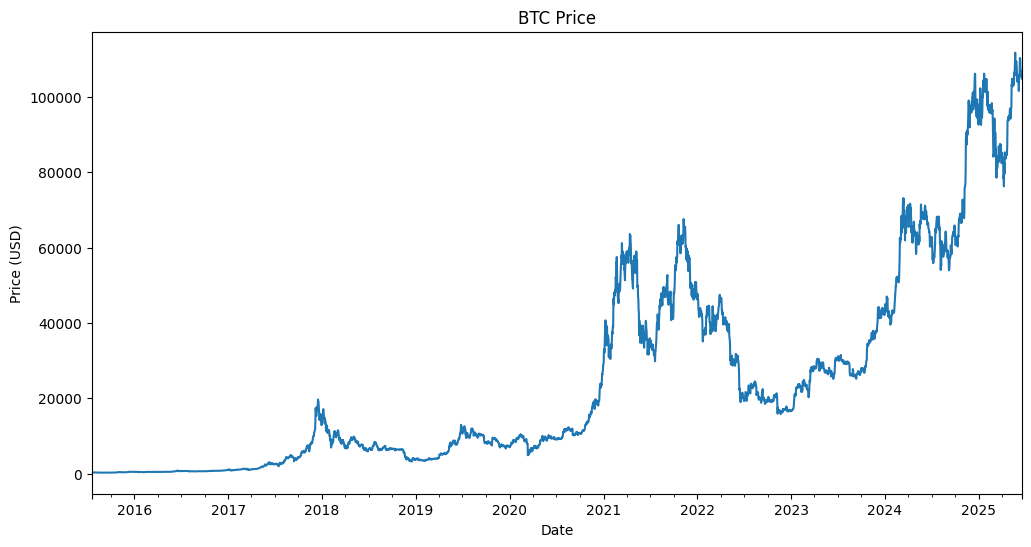

In [11]:
daily_data['close'].plot.line(title=f'{COIN} Price', figsize=(12, 6), ylabel='Price (USD)', xlabel='Date')

<Axes: ylabel='Frequency'>

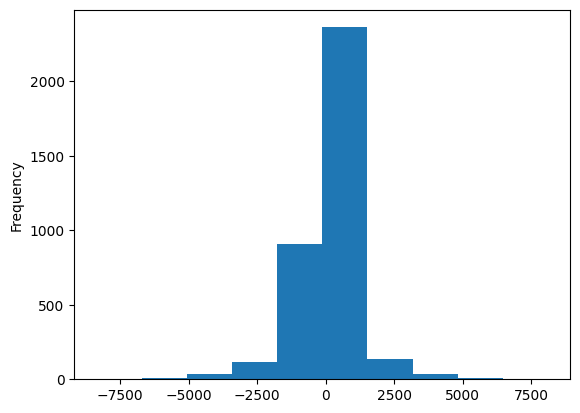

In [12]:
daily_data['gradient'].plot.hist()

In [13]:
daily_data['close'].describe()

count      3621.000000
mean      24720.381044
std       26841.610303
min         211.160000
25%        4164.520000
50%       11330.060000
75%       39524.270000
max      111722.530000
Name: close, dtype: float64

# Load the Transformer Model

Sequence the data to make it predict the next price

## Preprocess the data


In [14]:
seqs = []
nexts = []
for i in range(len(daily_data)):
    try:
        seq, next = sequence(daily_data['close'], i)
        seqs.append(seq)
        nexts.append(next)
    except Exception as e:
        print(f'Error at {i} Exception:', e)
        
seqs = [padding(seq, len(daily_data)) for seq in seqs]
daily_data['sequence'] = seqs
daily_data['next'] = nexts
daily_data[['sequence', 'next']].head()

,sequence,next
time,,
2015-07-20,"[-99999999.0, -99999999.0, -99999999.0, -99999...",277.32
2015-07-21,"[280.0, -99999999.0, -99999999.0, -99999999.0,...",277.89
2015-07-22,"[280.0, 277.32, -99999999.0, -99999999.0, -999...",277.39
2015-07-23,"[280.0, 277.32, 277.89, -99999999.0, -99999999...",289.12
2015-07-24,"[280.0, 277.32, 277.89, 277.39, -99999999.0, -...",289.70


## Load the Model

### Data Setup

In [15]:
testSize = len(daily_data)-30
train_data = daily_data.iloc[:testSize]
test_data = daily_data.iloc[testSize:]
test_data.index.min(), test_data.index.max()

(Timestamp('2025-05-19 00:00:00'), Timestamp('2025-06-17 00:00:00'))

In [16]:
X_train = train_data[['sequence']]
y_train = train_data['next']
X_test = test_data[['sequence']]
y_test = test_data['next']

In [17]:
from sklearn.preprocessing import StandardScaler

# Create scalers for both sequences and targets
sequence_scaler = StandardScaler()
target_scaler = StandardScaler()

# Normalize target values (Bitcoin close prices)
y_train_scaled = target_scaler.fit_transform(y_train.values.reshape(-1, 1)).flatten()
y_test_scaled = target_scaler.transform(y_test.values.reshape(-1, 1)).flatten()


# Apply normalization to sequence data
X_train_norm = pd.DataFrame({
    'sequences': normalize_sequences(X_train.iloc[:, 0], sequence_scaler)
})
X_test_norm = pd.DataFrame({
    'sequences': normalize_sequences(X_test.iloc[:, 0], sequence_scaler)
})
y_train_norm = pd.Series(y_train_scaled)
y_test_norm = pd.Series(y_test_scaled)

In [18]:
model = torch.load(f'../models/{COIN}_model.pth')

In [ ]:
# Create model with appropriate settings for Bitcoin prediction
model = BaseTransformer(
    d_model=128,
    num_heads=8,
    num_layers=4,
    learning_rate=1e-4,  # This is fine now with normalized data
    batch_size=32,
    dropout=0.1,
    mask_value=FILL
)
model.fit(X_train_norm, y_train_norm, epochs=100, validation_data=(X_test_norm, y_test_norm))
torch.save(model, f'../models/{COIN}_model.pth')

Data shapes - X: torch.Size([3591, 3621, 1]), y: torch.Size([3591, 1])
DataFrame column: sequences
Sample sequence length: 3621


Training Progress:   0%|          | 0/100 [00:00<?, ?it/s]

In [30]:
predictions = model.predict(X_test_norm)
predictions = target_scaler.inverse_transform(predictions).reshape(-1)
predictions = pd.Series(predictions, index=y_test.index)
y_test_norm.index = X_test_norm.index

rmse = root_mean_squared_error(y_test, predictions)
print(f"Test RMSE: {rmse:.4f}")

Test RMSE: 13558.0260


<Axes: title={'center': 'Difference on Prediction and Actual'}, xlabel='time'>

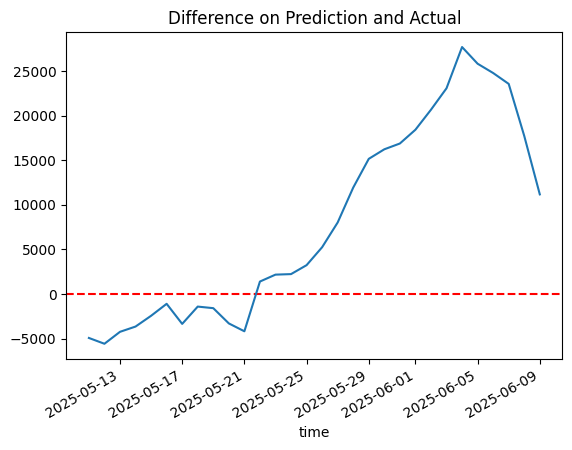

In [31]:
diff = predictions - y_test
plt.axhline(0.0, color='r', linestyle='--')
diff.plot.line(title='Difference on Prediction and Actual')

<Axes: title={'center': 'Predicted vs. Actual Value on Validation Month'}, xlabel='Date', ylabel='Price'>

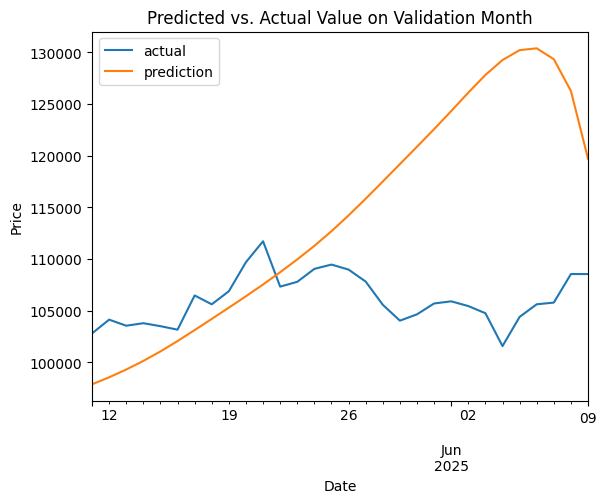

In [32]:
comparison = pd.concat([y_test, predictions], axis=1)
comparison.columns = ['actual', 'prediction']
comparison.plot.line(title='Predicted vs. Actual Value on Validation Month', xlabel='Date', ylabel='Price')

In [33]:
def predict_sequence(model, price, sequence_length=30, total_length=365):
    """
    Generate a sequence of predictions autoregressively
    
    Args:
        model: Your trained transformer
        initial_price: The last known Bitcoin price
        sequence_length: How many future prices to predict
        total_length: Total input length (365 in your case)
    """
    
    # Start with the initial price
    current_sequence = y_test.values.tolist()
    current_sequence.append(price)
    current_sequence = current_sequence[-total_length:]  # Keep only the last 'total_length' prices
    
    # Generate predictions one by one
    for i in range(sequence_length):
        # Create input array: current sequence + padding
        input_data = padding(current_sequence, target_length=total_length)
        
        # Create DataFrame for model input
        input_df = pd.DataFrame({'sequences': [input_data]})
        next_prediction = model.predict(input_df)[0][0]  # Extract scalar value
        next_prediction = target_scaler.inverse_transform([[next_prediction]])[0][0]
        
        # Add prediction to sequence
        current_sequence.append(next_prediction)
        current_sequence = current_sequence[-total_length:]  # Keep only the last 'total_length' predictions
    
    return current_sequence[1:(sequence_length+1)]

# Usage
last_known_price = y_test.values[-1]  # Your last known Bitcoin price
n = 20
predicted_sequence = predict_sequence(model, last_known_price, sequence_length=n)

<Axes: title={'center': '20-day Predicted Sequence'}, xlabel='Days Ahead from 6/9/2025', ylabel='Price (USD)'>

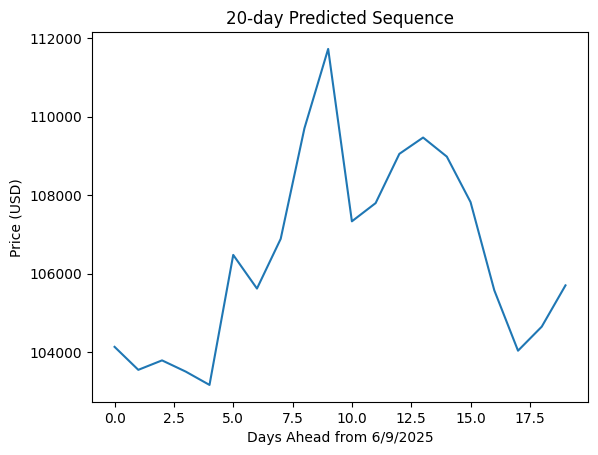

In [39]:
maxDate = y_test.index.max()

pd.Series(predicted_sequence).plot.line(title=f'{n}-day Predicted Sequence', ylabel='Price (USD)', xlabel=f'Days Ahead from {maxDate.month}/{maxDate.day}/{maxDate.year}')

count        20.000000
mean     106445.147000
std        2479.269688
min      103161.070000
25%      104106.610000
50%      106085.700000
75%      108109.082500
max      111722.530000
dtype: float64